## All neccesary imports

In [ ]:
# inspired by article https://blog.francium.tech/custom-object-training-and-detection-with-yolov3-darknet-and-opencv-41542f2ff44e
# before trying out, git clone https://github.com/AlexeyAB/darknet/
# copy dir custom_data to darknet

# add weights to darknet/custom_data/backup from link https://drive.google.com/drive/folders/17F-OpeF7VVyEIfoihltDBrgIG3vpIF5R


# change Makefile and set GPU=1 
# make clean && make

In [41]:
%matplotlib inline

import numpy as np
from PIL import Image
import numpy as np
import cv2 as cv
import os
import argparse

import cv2
import numpy as np
import glob

import pandas as pd


WIDTH = 480
HEIGHT = 360

## Preprocessing

In [ ]:
# transform train and test annotated images to txt file that is suitable for darknet

# test images should be stored in images/test/ and train images in images/train

def rect_to_txt(path, folder, real):
    boxes = []
    for png_file in glob.glob(path + '/*.png'):
        #print(png_file)
        image = cv.imread(png_file)
        imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(imgray, 127, 256, 0)
        contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        
        replaceimg = png_file.replace(folder, real)
        pah = replaceimg.split('.')[:-1]
        pahh = ".".join(pah)
        f = open(pahh+".txt", "w")
        for c in contours:
            x,y,w,h = cv.boundingRect(c)
            #print(x,y,w,h)
            WIDTH = 480
            HEIGHT = 360
            yp = y + h
            xp = x + w
            xmiddle = round((x + xp) / 2)
            ymiddle = round((y + yp) / 2)
            
            xcentre = xmiddle / WIDTH
            ycentre = ymiddle / HEIGHT
            
            hadj = w / WIDTH
            wadj = h / HEIGHT
            
            
            
            
            f.write(f"0 {xcentre} {ycentre} {hadj} {wadj}\n")
            
            #value = (0, replaceimg, int(x),int(y),int(xp),int(yp))
            #boxes.append(value)
        f.close()
        
    #column_name = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    #df = pd.DataFrame(boxes, columns=column_name)
    return 


for i, folder in enumerate(['trainannot_rect', 'testannot_rect']):
    if i == 0:
        real = "train"
    if i == 1:
        real = "test"
        
    image_path = os.path.join(os.getcwd(), ('images/' + folder))
    rect_to_txt(image_path, folder,  real)
    #xml_df.to_csv(('images/'+real+'_labels.csv'), index=None, header=False)
    print('Successfully converted xml to csv for', folder)
        

In [ ]:
# create test.txt and train.txt for darknet specification

# we will later move them to
for i, folder in enumerate(['trainannot_rect', 'testannot_rect']):
    if i == 0:
        real = "train"
    if i == 1:
        real = "test"
    
    path = os.path.join(os.getcwd(), ('images/' + real))
    f = open(real+".txt", "w")
    for png_file in glob.glob(path + '/*.png'):
        new = f"custom_data/{real}/{png_file.split('/')[-1]}"
        print(new)
        f.write(new+"\n")
        
    f.close()
        

# Logic and evaluation and TODOs

In [6]:
def get_iou(box1, box2):
    """
    box1 -- first box, list object with coordinates (x1, y1, h, w)
    box2 -- second box, list object with coordinates (x1, y1, h, w)
    """
    box1[2]+=box1[0]
    box1[3]+=box1[1]
    box2[2]+=box2[0]
    box2[3]+=box2[1]

    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3]) 
    inter_area = (yi2-yi1)*(xi2-xi1)
  
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area+box2_area-inter_area

    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou


In [15]:
# calculate tp, fp, fn for static values

CONF_THRESH, NMS_THRESH = 0.5, 0.5
#thon show.py --image test/0002.png --config cfg/yolov3.cfg --weights backup/yolov3custom_900.weights --names custom.names 
# Load the network
# static threshold
config="darknet/custom_data/cfg/yolotiny.cfg"
image_dict="darknet/custom_data/test/"
weights="darknet/custom_data/backup/yolotiny_30000.weights"
names="darknet/custom_data/custom.names"

net = cv2.dnn.readNetFromDarknet(config, weights)
#net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the output layer from YOLO
layers = net.getLayerNames()
output_layers = [layers[i[0] - 1] for i in net.getUnconnectedOutLayers()]

tp = 0
fp = 0
fn = 0

for image in glob.glob(image_dict + '/*.png'):
    # Read and convert the image to blob and perform forward pass to get the bounding boxes with their confidence scores
    img = cv2.imread(image)
    height, width = img.shape[:2]


    # get ground truth from txt
    img_meta = image.split('.')[0] + ".txt"

    truth_bbox = []
    f = open(img_meta, 'r') 
    for line in f.readlines():

        res =line.rstrip('\n').split(' ')
        res = [float(i) for i in res]

        _,center_x ,center_y , w ,h = res
        x = center_x - w / 2
        y = center_y - h / 2
        truth_bbox.append([int(x* WIDTH),int(y* HEIGHT) ,int(w* WIDTH) ,int(h*HEIGHT)])

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)
    class_ids, confidences, b_boxes = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # classifies as acceptable
            if confidence > CONF_THRESH:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)


                b_boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(int(class_id))



    for tbox in truth_bbox:
        max_iou = 0
        for bbox in b_boxes:
            
            if get_iou(tbox,bbox) > 0.5:
                max_iou = get_iou(tbox,bbox)
                
        if max_iou:
            tp += 1
        else:
            fn += 1
    
    for bbox in b_boxes:
        max_iou = 0
        for tbox in truth_bbox:
            if get_iou(tbox,bbox) > 0.5:
                max_iou = get_iou(tbox,bbox)

        if not max_iou:
            fp += 1


print(tp, fn, fp)

    # Perform non maximum suppression for the bounding boxes to filter overlapping and low confident bounding boxes
    #indices = list(cv2.dnn.NMSBoxes(b_boxes, confidences, CONF_THRESH, NMS_THRESH))



194 94 37


In [122]:
# Determinating threshold for model

from sklearn import metrics
import numpy as np

CONF_THRESH, NMS_THRESH = 0.5, 0.5
#thon show.py --image test/0002.png --config cfg/yolov3.cfg --weights backup/yolov3custom_900.weights --names custom.names 
# Load the network

config="darknet/custom_data/cfg/yolotiny.cfg"
image_dict="darknet/custom_data/test/"
weights="darknet/custom_data/backup/yolotiny_30000.weights"
names="darknet/custom_data/custom.names"

net = cv2.dnn.readNetFromDarknet(config, weights)
#net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the output layer from YOLO
layers = net.getLayerNames()
output_layers = [layers[i[0] - 1] for i in net.getUnconnectedOutLayers()]

tp = 0
fp = 0
fn = 0
y_tru = []
y_pred = []
for image in glob.glob(image_dict + '/*.png'):
    # Read and convert the image to blob and perform forward pass to get the bounding boxes with their confidence scores
    img = cv2.imread(image)
    height, width = img.shape[:2]


    # get ground truth from txt
    img_meta = image.split('.')[0] + ".txt"

    truth_bbox = []
    f = open(img_meta, 'r') 
    for line in f.readlines():

        res =line.rstrip('\n').split(' ')
        res = [float(i) for i in res]

        _,center_x ,center_y , w ,h = res
        x = center_x - w / 2
        y = center_y - h / 2
        truth_bbox.append([int(x* WIDTH),int(y* HEIGHT) ,int(w* WIDTH) ,int(h*HEIGHT)])

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)
    class_ids, confidences, b_boxes = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > 0.05:
            # classifies as acceptable
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                

                b_boxes.append(([x, y, int(w), int(h)], confidence))
                #confidences.append(float(confidence))
                #class_ids.append(int(class_id))



    
    for bbox, thre in b_boxes:
        max_iou = 0
        max_thre = 0
        for tbox in truth_bbox:
            if get_iou(tbox,bbox) > 0.5:
                max_iou = get_iou(tbox,bbox)
                max_thre = thre

        if not max_iou:
            y_tru.append(0.0)
            y_pred.append(thre)

    for tbox in truth_bbox:
        max_iou = 0
        max_thre = 0

        for bbox, thre in b_boxes:
            if get_iou(tbox,bbox) > 0.5:
                max_iou = get_iou(tbox,bbox)
                max_thre = thre

        if max_iou:
            y_tru.append(1.0)
            y_pred.append(max_thre)
        else:
            y_tru.append(0.0)
            y_pred.append(max_thre)

    # Perform non maximum suppression for the bounding boxes to filter overlapping and low confident bounding boxes
    #indices = list(cv2.dnn.NMSBoxes(b_boxes, confidences, CONF_THRESH, NMS_THRESH))




In [123]:
y_tru = np.array(y_tru)
y_pred = np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_tru, y_pred)

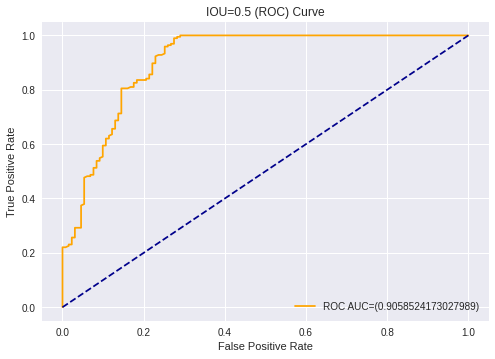

In [125]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC AUC=('+str(auc(fpr,tpr))+")")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('IOU=0.5 (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)
print()

In [134]:
threshold = max(tpr-fpr)

0.7149344294382463

In [143]:
average_precision_score(y_tru, y_pred)

0.917097994351696

In [144]:
compare_tru = y_tru == 1.0
compare_pred = y_pred > threshold

In [146]:
precision_score(compare_tru, compare_pred), recall_score(compare_tru, compare_pred), f1_score(compare_tru, compare_pred)

(0.8564593301435407, 0.9179487179487179, 0.8861386138613861)

In [ ]:
# Calculating mAP with darknet methods
# ./darknet detector map custom_data/detector.data custom_data/cfg/yolotiny.cfg custom_data/backup/yolotiny_20000.weights -iou_thresh 0.75
"""

calculation mAP (mean average precision)...
 Detection layer: 15 - type = 27 
252
 detections_count = 3332, unique_truth_count = 288  
class_id = 0, name = ear, ap = 74.14%   	 (TP = 209, FP = 65) 

 for conf_thresh = 0.25, precision = 0.76, recall = 0.73, F1-score = 0.74 
 for conf_thresh = 0.25, TP = 209, FP = 65, FN = 79, average IoU = 56.05 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.741424, or 74.14 % 
Total Detection Time: 137 Seconds

Set -points flag:
 `-points 101` for MS COCO 
 `-points 11` for PascalVOC 2007 (uncomment `difficult` in voc.data) 
 `-points 0` (AUC) for ImageNet, PascalVOC 2010-2012, your custom dataset


Done! Loaded 16 layers from weights-file 

 calculation mAP (mean average precision)...
 Detection layer: 15 - type = 27 
252
 detections_count = 3332, unique_truth_count = 288  
class_id = 0, name = ear, ap = 24.07%   	 (TP = 96, FP = 178) 

 for conf_thresh = 0.25, precision = 0.35, recall = 0.33, F1-score = 0.34 
 for conf_thresh = 0.25, TP = 96, FP = 178, FN = 192, average IoU = 28.80 % 

 IoU threshold = 75 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.75) = 0.240711, or 24.07 % 
Total Detection Time: 142 Seconds


"""

In [ ]:
# Nice to have TODO create google colab notebook